# Sampling from regions of low epistemic uncertainty

In this notebook, we consider epistemic uncertainty $E(x) \equiv \mathcal{U}_\text{epis}(x)$ (usually $\mathcal{U}_\text{epis}(x) \equiv \sigma_f^2(x)$ where $\sigma_f^2(x)$ is the variance of the posterior over function values $p(f \mid \mathcal{D}, x)$). The corresponding pdf is proportional to $f(x) \propto \exp \big\{ - E(x) / T \big\}$, where $T$ denotes the temperature. Choosing a low temperature ensures that samples are most likely when they lie in low energy regions.

In [1]:
#import gpytorch
from argparse import Namespace
from datetime import datetime
from hypnettorch.data.special.donuts import Donuts
from hypnettorch.utils.hmc import HMC, MCMC
from hypnettorch.utils.sim_utils import setup_environment
from hypnettorch.utils import misc as hmisc
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared
from sklearn.metrics import roc_auc_score
import sys
from time import time
import torch
from torchvision.datasets import KMNIST

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)
    
from nngp.nngp import inference_with_isotropic_gaussian_ll, gen_inference_kernels, \
    cholesky_adaptive_noise
from utils import notebook as nutils
from utils.plotting import heatmap
from utils.misc import eval_grid_2d, calc_regression_acc

from IPython.display import display, Markdown, Latex
#display(Markdown('*some markdown* $\phi$'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './out/sampling_epistemic/run_' + \
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='sampling_logger')

Created output folder ./out/sampling_epistemic/run_2021-10-04_14-05-00.
10/04/2021 02:05:00 PM - INFO - Using cuda: False


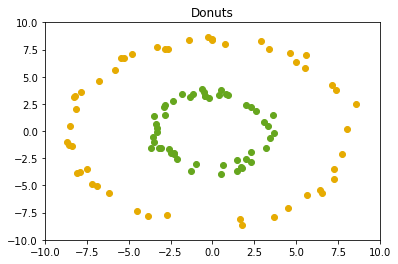

In [3]:
data = Donuts(centers=((0, 0), (0, 0)), radii=((3,4), (8,9)),
              num_train=50, num_test=100,
              use_one_hot=False, rseed=42)
X = data.get_train_inputs()
Y = data.get_train_outputs().squeeze()

#data.plot_dataset('Donuts Dataset')

colors = hmisc.get_colorbrewer2_colors(family='Dark2')

plt.title('Donuts')
plt.scatter(X[Y==0,0], X[Y==0,1], c=colors[4])
plt.scatter(X[Y==1,0], X[Y==1,1], c=colors[5])
plt.ylim(-10, 10)
plt.xlim(-10, 10)
plt.show()

# We use symmetrical values -1 / 1 for classification
Y[Y==0] = -1

In [4]:
grid_X1, grid_X2, grid_X = eval_grid_2d(x_range=(-20, 20), y_range=(-20, 20), res_per_unit=10,
                                        verbose=True)

# Translate grid to PyTorch tensor.
X_train = torch.from_numpy(X.astype(np.float32)).to(device)
Y_train = torch.from_numpy(Y.astype(np.float32)).to(device)
X_test = torch.from_numpy(grid_X.astype(np.float32)).to(device)

heatmap_kwargs = {
    'grid_X': grid_X1,
    'grid_Y': grid_X2,
    'show_title': False,
    'num_levels': 100,
    'log_levels': False,
    'crop': False,
    'xticks': [-15, -10, -5, 0, 5, 10, 15],
    'yticks': [-15, -10, -5, 0, 5, 10, 15],
    'data_in': X,
    'data_trgt': Y,
    'out_dir': config.out_dir,
    'ts': 30,
    'lw': 15, 
    'figsize': (12, 7)
}

Grid resolution: 400 x 400.


In [5]:
likelihood_var = 1e-2

In [6]:
## Define MLP architectures to be considered
num_mc = 100000

nngp_kernel_properties = [
    ### Relu - Analytic ###
    {'name': 'ana_relu_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_4l', 'type': 'analytic',
     'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Error Function - Analytic ###
    {'name': 'ana_erf_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_4l', 'type': 'analytic',
     'params': {'n_layer': 4, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Sigmoid ###
    #{'name': 'sigmoid_1l', 'type': 'mc',
    # 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'sigmoid_2l', 'type': 'mc',
    # 'params': {'n_layer': 2, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'sigmoid_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Tanh ###
    #{'name': 'tanh_1l', 'type': 'mc',
    # 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'tanh_2l', 'type': 'mc',
    # 'params': {'n_layer': 2, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'tanh_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Cos ###
    {'name': 'ana_cos_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
]

nngp_kernel_properties = [
    {'name': 'ana_relu_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_cos_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
]

In [7]:
#%%script false --no-raise-error # Do not execute cell.

nutils.compute_kernel_values(nngp_kernel_properties, X_test, X_train, Y_train,
                             nutils.determine_mlp_kernel_func, test_bs=500,
                             out_dir=config.out_dir, try_inference=False)

Investiagting **ana_relu_1l**

  0%|          | 0/160000 [00:00<?, ?it/s]

Kernel computation took 0.673825 seconds.

Investiagting **ana_cos_1l**

  0%|          | 0/160000 [00:00<?, ?it/s]

Kernel computation took 0.327332 seconds.

In [8]:
%%script false --no-raise-error # Do not execute cell.

nutils.load_kernel_values(nngp_kernel_properties,
    out_dir='./out/sampling_epistemic/all_kernels', device=device)

All models use the likelihood **0.010000** ...

Working on **ana_relu_1l** ...

Training accuracy: 100.00%

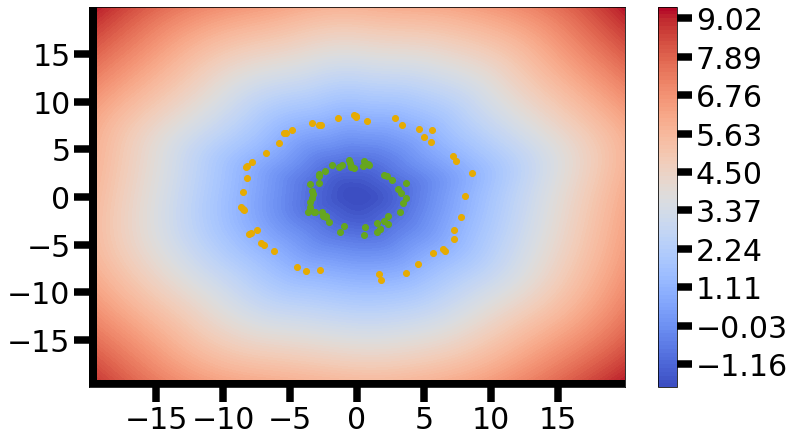

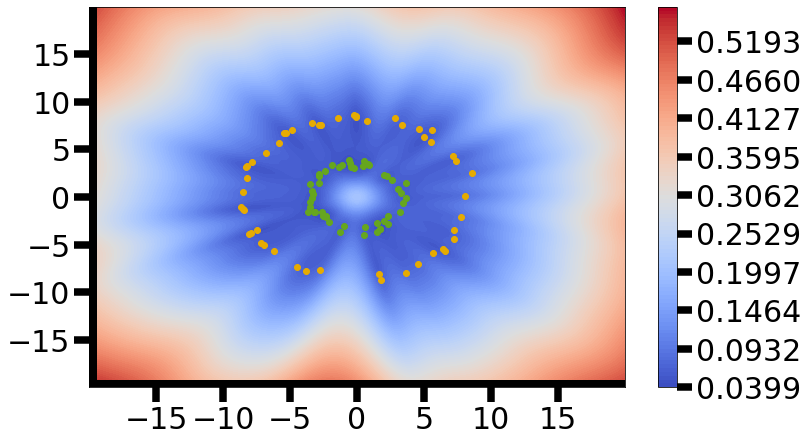

Working on **ana_cos_1l** ...

Training accuracy: 100.00%

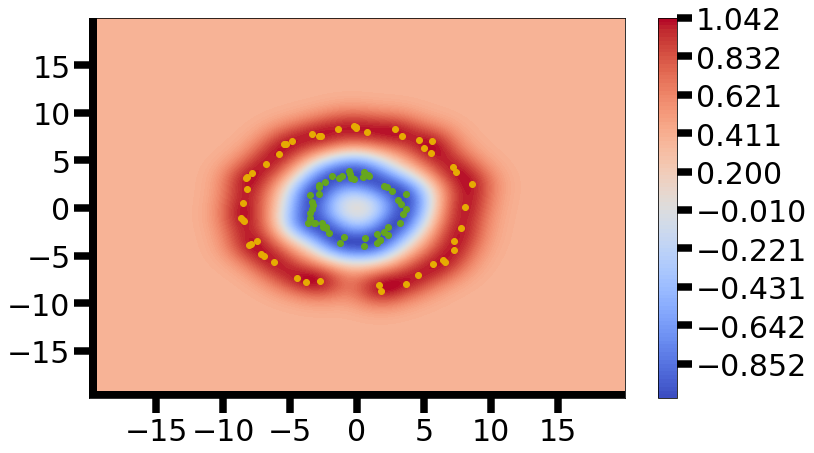

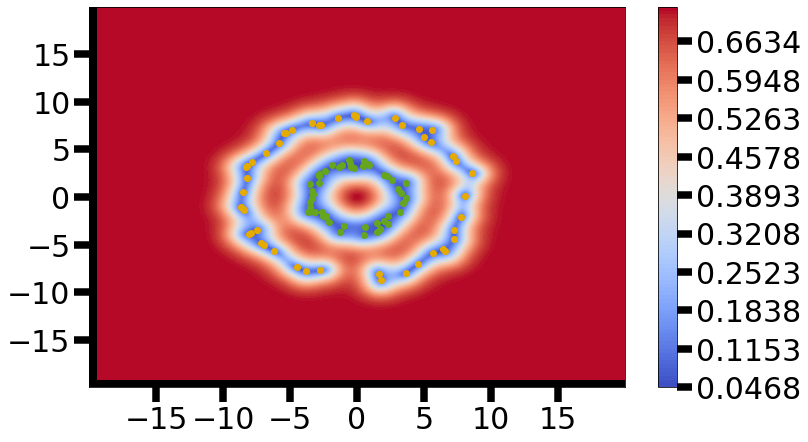

In [9]:
display(Markdown('All models use the likelihood **%f** ...' % (likelihood_var))) 

with torch.no_grad():
    for i, k_props in enumerate(nngp_kernel_properties):    
        display(Markdown('Working on **%s** ...' % (k_props['name']))) 

        if 'K_train' not in k_props.keys():
            continue

        K_train = k_props['K_train']
        K_test = k_props['K_test']
        K_all = k_props['K_all']
        
        try:
            train_mean, train_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, torch.diagonal(K_train), K_train, \
                var=likelihood_var)
            display(Markdown('Training accuracy: %.2f%%' \
                  % calc_regression_acc(train_mean, Y_train)))
        except:
            display(Markdown('**WARN** Could not compute training accuracy for **%s**.' \
                             % (k_props['name'])))

        try:
            test_mean, test_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, K_test, K_all, var=likelihood_var)
        except:
            L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
            display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                             % (ll_var, k_props['name'])))
            test_mean, test_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, K_test, K_all, L_mat=L, var=ll_var)

        def check_nan(tensor, ident):
            if torch.any(torch.isnan(tensor)):
                nan_mask = torch.isnan(tensor)
                display(Markdown('**%d NaN values in %s.**' \
                        % (nan_mask.sum(), ident)))
                tensor[nan_mask] = 0

        check_nan(test_mean, 'predictive mean')
        check_nan(test_var, 'predictive variance')
        
        grid_post_std = torch.sqrt(test_var.cpu())
        k_props['grid_post_std'] = grid_post_std
        heatmap(test_mean.cpu(), title='Posterior Predictive Mean - %s' % (k_props['name']), **heatmap_kwargs)
        heatmap(grid_post_std, title='Posterior Predictive Std - %s' % (k_props['name']), **heatmap_kwargs)

In [10]:
def rejection_sampling(num_samples, pdf_func, max_val, grid_ranges):
    d = len(grid_ranges)
    
    gwidths = torch.ones(d)
    gstarts = torch.zeros(d)
    
    for i, (a, b) in enumerate(grid_ranges):
        gwidths[i] *= b - a
        gstarts[i] += a
    
    samples = []
    while len(samples) < num_samples:
        x = torch.rand(d) * gwidths + gstarts
        u = torch.rand(1)
        
        p_x = pdf_func(x)
        
        if u <= p_x / max_val:
            samples.append(x.detach().cpu().numpy())
        
    return np.vstack(samples)

Working on **ana_relu_1l** ...

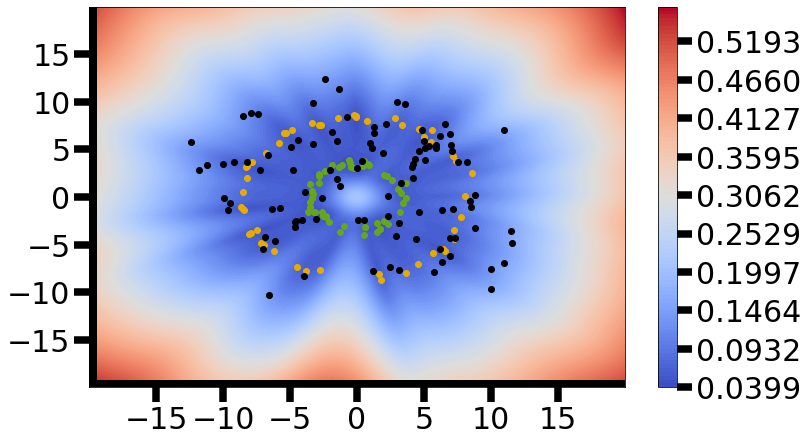

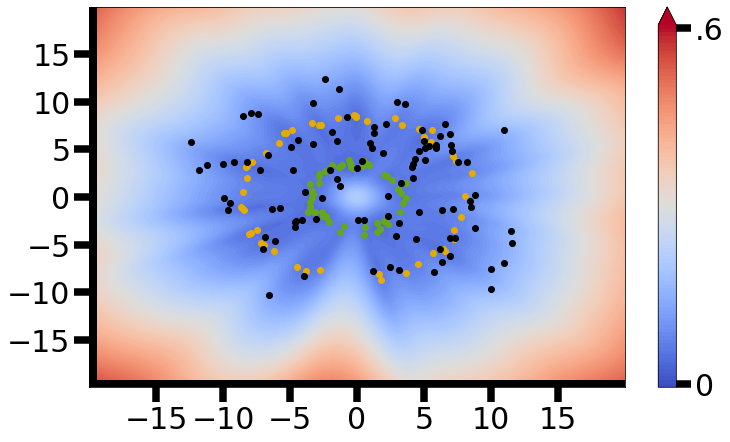

Working on **ana_cos_1l** ...

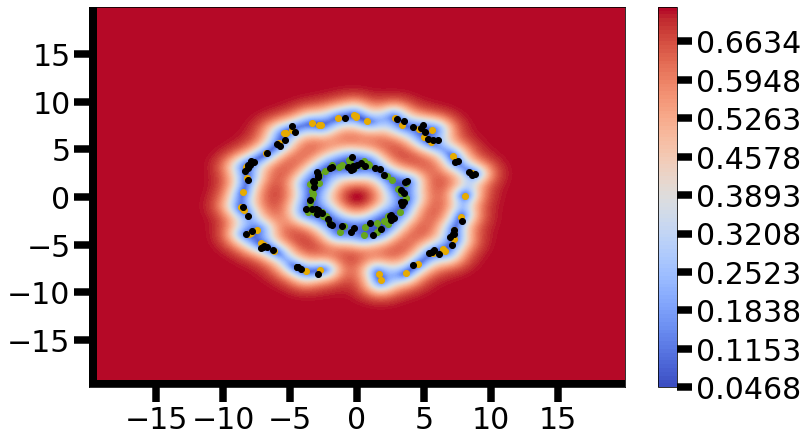

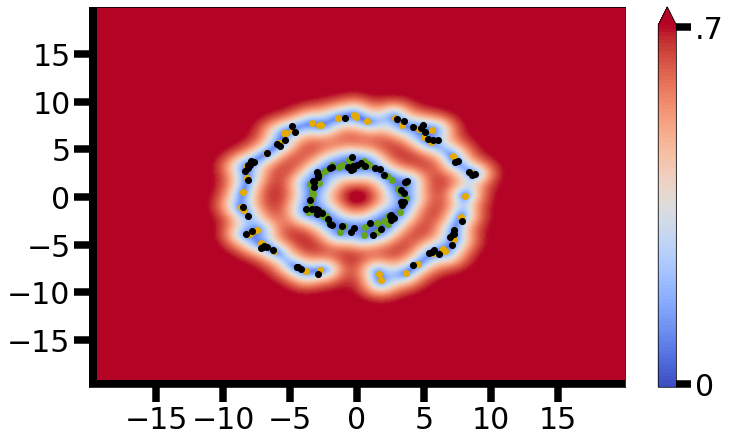

In [14]:
init_position = torch.from_numpy(data.next_test_batch(1)[0].squeeze()).float().to(device)

for i, k_props in enumerate(nngp_kernel_properties): 
    #if i != 6:
    #    continue

    display(Markdown('Working on **%s** ...' % (k_props['name']))) 

    if 'K_train' not in k_props.keys():
        #continue
        raise Exception()

    K_train = k_props['K_train']

    def pot_energy(pos):
        _, K_test, K_all = \
            gen_inference_kernels(X_train, pos.view(1, -1),
                nutils.determine_mlp_kernel_func(k_props),
                compute_K_train=False, full_K_test=False)

        _, pos_var = inference_with_isotropic_gaussian_ll( \
            Y_train, K_train, K_test, K_all, var=likelihood_var)

        return pos_var

    if False:
        T = .05
    
        #hmc = HMC(init_position, pot_energy, stepsize=.0002, num_steps=10, 
        #          inv_mass=1., logger=logger, log_interval=50, writer=writer,
        #          writer_tag=k_props['name'])
        #hmc.simulate_chain(10)

        mcmc = MCMC(init_position, lambda p : pot_energy(p) / T, proposal_std=1., logger=logger,
                    log_interval=500, writer=writer, writer_tag=k_props['name'])
        mcmc.simulate_chain(20000)

        mcmc_samples = [mcmc.position_trajectory[i].detach().cpu().numpy() for i in range(500, len(mcmc.position_trajectory), 500)]
        #mcmc_samples = [t.detach().cpu().numpy() for t in mcmc.position_trajectory]
        mcmc_samples = np.vstack(mcmc_samples)

        heatmap(k_props['grid_post_std'], title='Posterior Predictive Std - %s' % (k_props['name']),
                samples_in=mcmc_samples, **heatmap_kwargs)
    else:
        def pot_to_pdf(pos, temp=1.):    
            return energy_to_pdf(pot_energy(pos), temp=temp)

        def energy_to_pdf(energy, temp=1.):    
            return torch.exp(-energy / temp)

        T = .01

        grid_post_pdf = energy_to_pdf(k_props['grid_post_std']**2, temp=T)

        ar_samples = rejection_sampling(100, lambda e: pot_to_pdf(e, temp=T), grid_post_pdf.max() + 1e-5, [[-20, 20], [-20, 20]])

        heatmap(k_props['grid_post_std'], title='Posterior Predictive Std - %s' % (k_props['name']),
                samples_in=ar_samples, **heatmap_kwargs)
        
        if k_props['name'] == 'ana_relu_1l':
            heatmap(k_props['grid_post_std'], title='Posterior Predictive Std - %s' % (k_props['name']),
                vmin=0, vmax=.6, force_extend='max', cticks=[.005, 0.595],
                ctick_lbls=['0', '.6'], filename='unc_samples_post_std_%s' % k_props['name'],
                samples_in=ar_samples, **heatmap_kwargs)
        if k_props['name'] == 'ana_cos_1l':
            heatmap(k_props['grid_post_std'], title='Posterior Predictive Std - %s' % (k_props['name']),
                vmin=0, vmax=.7, force_extend='max', cticks=[.0065, 0.695],
                ctick_lbls=['0', '.7'], filename='unc_samples_post_std_%s' % k_props['name'],
                samples_in=ar_samples, **heatmap_kwargs)